In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import *
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")

# Calculate features

In [2]:
def compute_features(df):
    # intraday return features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17res'
    features = temp.reset_index()

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # 17:30 ma raw return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3raw'] = features['17ma1raw'] - features['17ma3raw']
    features['17ma1-5raw'] = features['17ma1raw'] - features['17ma5raw']
    features['17ma1-20raw'] = features['17ma1raw'] - features['17ma20raw']

    # 17:30 ma residual return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3res'] = features['17ma1res'] - features['17ma3res']
    features['17ma1-5res'] = features['17ma1res'] - features['17ma5res']
    features['17ma1-20res'] = features['17ma1res'] - features['17ma20res']

    # market value
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id') * df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'market_value'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # intraday volume features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='16:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') - df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')) / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # turnover ma
    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma1'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma3'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma5'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma20'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # original features 
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='estVol winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'estVol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid16'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid10'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'vol17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # Normalization
    #features.iloc[:,2:] = (features.iloc[:,2:] - features.iloc[:,2:].mean())/features.iloc[:,2:].std()

    # Merging with target
    target = df[df["Time"] == "17:30:00.000"][['Date','Id','ResidualNoWinsorCumReturn winsorized']].copy()
    merged = features.merge(target ,on =['Date','Id']).drop_duplicates()
    merged = merged.sort_values(['Id','Date'],ascending = [True, True])
    merged["y"] = merged.groupby(['Id'])["ResidualNoWinsorCumReturn winsorized"].shift(-1)
    merged = merged.dropna(how = 'any')
    merged = merged.sort_values('Date',ascending=True)
    merged_with_dates = merged
    merged_with_dates.to_csv("merged_with_dates.csv")
    merged = merged.drop(["Id", "Date","ResidualNoWinsorCumReturn winsorized"], axis = 1)
    merged.to_csv('beforeTrainning.csv')
    return merged, merged_with_dates

In [3]:
df = pd.read_csv(r"C:\Users\Lenovo\Python workshop\project\merged_data_fillna_timeid.csv", sep = ",")
m, mwd = compute_features(df)
m

,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,17ma1-3raw,17ma1-5raw,...,turnover_ma1,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,y
19,-0.014479,0.004383,0.003725,0.001532,-0.002551,-4.328447e-03,0.012672,0.001606,0.001777,-0.015223,...,5127.454439,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,-0.017619
521779,0.006544,0.019172,0.001098,-0.002364,-0.013599,-4.222190e-03,-0.015091,-0.002486,-0.009377,0.001492,...,4172.375545,3466.191410,3757.401356,2936.059761,0.178838,17.535980,17.494583,17.875440,4175388.0,-0.000857
523534,0.007003,0.021363,0.002370,0.001177,-0.018284,-6.530792e-04,0.000158,-0.004395,-0.017631,-0.018442,...,1364.178894,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,0.005427
524559,0.000216,0.014031,0.003584,-0.001199,-0.008458,-5.796803e-03,-0.004567,0.005819,-0.002661,-0.003891,...,1991.979684,1418.626035,1253.361174,1726.009481,0.255014,8.605063,8.594749,8.726646,882447.0,0.022712
525278,-0.009049,0.006995,-0.003221,-0.005797,0.006212,-1.123333e-08,-0.007774,-0.000493,0.006212,0.013987,...,1544.120471,1322.711271,1227.455657,1456.009146,0.198565,20.052948,19.937037,20.193700,305566.0,-0.001233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474687,-0.003156,-0.002843,-0.002389,-0.000601,0.000601,1.659979e-03,0.001832,0.004811,-0.001059,-0.001230,...,755.496437,859.870155,1097.978782,2185.348603,0.124384,109.489080,109.423294,109.178300,69860.0,0.005219
620200,-0.005474,-0.005335,-0.005509,-0.002454,0.000700,2.318624e-03,-0.000727,0.000411,-0.001619,0.001427,...,1072.835540,1005.341016,1437.991572,2256.730451,0.097487,85.336110,85.126970,84.881970,139268.0,0.001534
11908,0.002591,0.004417,0.002889,0.005610,0.001834,5.823757e-03,0.004319,0.003771,-0.003990,-0.002486,...,3146.915786,3221.191763,2999.656179,3712.759845,0.159906,47.260170,47.526077,47.469370,139122.0,0.001472
719403,0.009592,0.006035,0.002739,0.002199,-0.011761,5.547418e-03,0.009233,-0.000683,-0.017308,-0.020993,...,882.373592,592.626950,938.420333,1328.093235,0.174713,12.221778,12.248676,12.295748,379523.0,0.001981


In [4]:
mwd

,Id,Date,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,...,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,ResidualNoWinsorCumReturn winsorized,y
19,ID000BC0991,20140129,-0.014479,0.004383,0.003725,0.001532,-0.002551,-4.328447e-03,0.012672,0.001606,...,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,0.006927,-0.017619
521779,ID000FBCLZ0,20140129,0.006544,0.019172,0.001098,-0.002364,-0.013599,-4.222190e-03,-0.015091,-0.002486,...,3466.191410,3757.401356,2936.059761,0.178838,17.535980,17.494583,17.875440,4175388.0,-0.011139,-0.000857
523534,ID000FD8FS2,20140129,0.007003,0.021363,0.002370,0.001177,-0.018284,-6.530792e-04,0.000158,-0.004395,...,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,-0.011686,0.005427
524559,ID000FDL8Z5,20140129,0.000216,0.014031,0.003584,-0.001199,-0.008458,-5.796803e-03,-0.004567,0.005819,...,1418.626035,1253.361174,1726.009481,0.255014,8.605063,8.594749,8.726646,882447.0,-0.006415,0.022712
525278,ID000FG1LV5,20140129,-0.009049,0.006995,-0.003221,-0.005797,0.006212,-1.123333e-08,-0.007774,-0.000493,...,1322.711271,1227.455657,1456.009146,0.198565,20.052948,19.937037,20.193700,305566.0,0.009924,-0.001233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474687,ID000CTT0J0,20171228,-0.003156,-0.002843,-0.002389,-0.000601,0.000601,1.659979e-03,0.001832,0.004811,...,859.870155,1097.978782,2185.348603,0.124384,109.489080,109.423294,109.178300,69860.0,-0.000399,0.005219
620200,ID000N4B6Z1,20171228,-0.005474,-0.005335,-0.005509,-0.002454,0.000700,2.318624e-03,-0.000727,0.000411,...,1005.341016,1437.991572,2256.730451,0.097487,85.336110,85.126970,84.881970,139268.0,0.004060,0.001534
11908,ID000BC2356,20171228,0.002591,0.004417,0.002889,0.005610,0.001834,5.823757e-03,0.004319,0.003771,...,3221.191763,2999.656179,3712.759845,0.159906,47.260170,47.526077,47.469370,139122.0,0.003889,0.001472
719403,ID0025RP8D1,20171228,0.009592,0.006035,0.002739,0.002199,-0.011761,5.547418e-03,0.009233,-0.000683,...,592.626950,938.420333,1328.093235,0.174713,12.221778,12.248676,12.295748,379523.0,-0.021521,0.001981


In [64]:
mwd.to_csv("mvd.csv", index = False)

# Feature selection

## VIF

In [5]:
data_scaled = normalize(m)
data_scaled = pd.DataFrame(data_scaled, columns = m.columns)

In [6]:
data_scaled.var()

10/17res         2.304401e-14
10/17raw         2.969111e-14
16/17res         6.137033e-15
16/17raw         7.834928e-15
17ma1raw         4.580592e-14
17ma3raw         1.545220e-14
17ma5raw         1.015974e-14
17ma20raw        2.908818e-15
17ma1-3raw       3.659202e-14
17ma1-5raw       4.163007e-14
17ma1-20raw      4.541518e-14
17ma1res         3.265541e-14
17ma3res         1.056848e-14
17ma5res         6.387751e-15
17ma20res        2.223070e-15
17ma1-3res       2.462884e-14
17ma1-5res       2.803963e-14
17ma1-20res      3.182838e-14
market_value     6.497529e-03
10/17vol         1.446054e-10
16/17vol         1.595024e-10
turnover_ma1     2.875635e-04
turnover_ma3     4.626520e-04
turnover_ma5     5.544674e-04
turnover_ma20    9.216269e-04
estVol           1.520909e-11
cleanMid17       6.274588e-06
cleanMid16       6.274642e-06
cleanMid10       6.276366e-06
vol17            2.368051e-03
y                4.872504e-14
dtype: float64

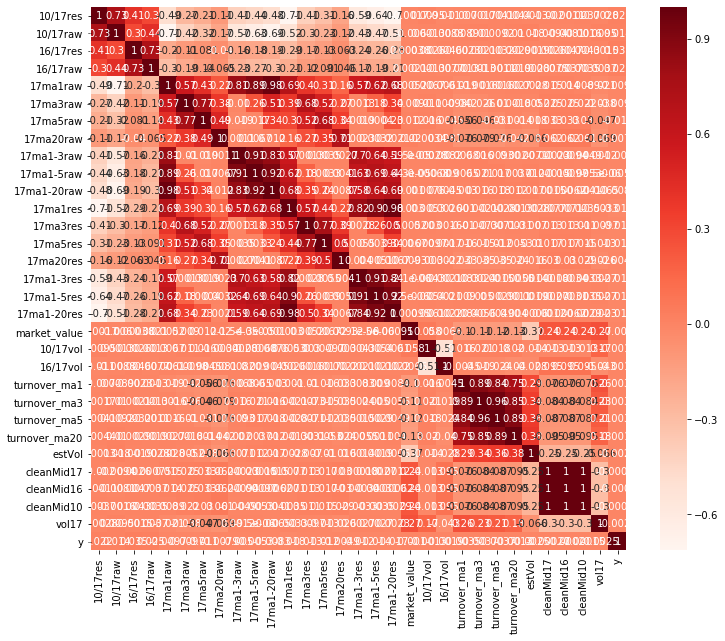

In [7]:
# feature hotmap captures only the pairwise correlation between the features
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = m.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
def calculateVIF(X):
    vif_data = pd.DataFrame({
        "Names": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data

In [9]:
vif = calculateVIF(m)
while(vif["VIF"].max() >= 10):
    drop_var = vif[vif.VIF == vif["VIF"].max()]["Names"]
    m = m.drop(drop_var, axis = 1)
    vif = calculateVIF(m)

In [10]:
m.columns.shape

(16,)

In [11]:
m.columns

Index(['10/17res', '10/17raw', '16/17res', '16/17raw', '17ma3raw', '17ma3res',
       '17ma5res', 'market_value', '10/17vol', '16/17vol', 'turnover_ma1',
       'turnover_ma20', 'estVol', 'cleanMid17', 'vol17', 'y'],
      dtype='object')

# Train-valid-test split

In [12]:
# train, test data split
train_valid = m.loc[list(mwd[mwd["Date"] < 20170101].index)] # 2014-2016
test = m.loc[list(mwd[mwd["Date"] >= 20170101].index)] # 2017

X_train_valid, y_train_valid = train_valid.iloc[: , :-1], train_valid["y"]
X_test, y_test = test.iloc[: , :-1], test["y"]

# # scale the features in train set
# sc = StandardScaler()
# X_train_valid_scaled = sc.fit_transform(X_train_valid)
# X_train_valid_scaled = pd.DataFrame(data = X_train_valid_scaled, columns = X_train_valid.columns, index = X_train_valid.index)

# # do the same scaling to test set
# X_test_scaled = sc.transform(X_test)
# X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

X_train = X_train_valid.loc[list(mwd[mwd["Date"] < 20160101].index)] # 2014-2015
X_valid = X_train_valid.loc[list(mwd[(mwd["Date"] >= 20160101) & (mwd["Date"] < 20170101)].index)] # 2016
y_train = m.loc[list(mwd[mwd["Date"] < 20160101].index)]["y"]
y_valid = m.loc[list(mwd[(mwd["Date"] >= 20160101) & (mwd["Date"] < 20170101)].index)]["y"]


# X_train_scaled = X_train_valid_scaled.loc[list(mwd[mwd["Date"] < 20160101].index)] # 2014-2015
# X_valid_scaled = X_train_valid_scaled.loc[list(mwd[(mwd["Date"] >= 20160101) & (mwd["Date"] < 20170101)].index)] # 2016
# y_train = m.loc[list(mwd[mwd["Date"] < 20160101].index)]["y"]
# y_valid = m.loc[list(mwd[(mwd["Date"] >= 20160101) & (mwd["Date"] < 20170101)].index)]["y"]

# X_train_valid_scaled = X_train_valid_scaled.reset_index(drop=True)
# X_train_scaled = X_train_scaled.reset_index(drop=True)
# X_valid_scaled = X_valid_scaled.reset_index(drop=True)

In [13]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_train_valid.shape, y_train_valid.shape, X_test.shape, y_test.shape

((378660, 15),
 (378660,),
 (195707, 15),
 (195707,),
 (574367, 15),
 (574367,),
 (194715, 15),
 (194715,))

# Cross validation

In [14]:
def weighted_mse(model, y_true, X):
    r2_weight = 1 / np.array(X['estVol'])
    r2_weight = r2_weight / r2_weight.sum()
    y_pred = model.predict(X)
    return r2_score(y_true, y_pred, sample_weight = r2_weight)

def cv_evaluate(model, X, y, X_test, y_test, how, cv_folds = 5):
    # cross validation
    cv_train_r2, cv_valid_r2 = [], []    
    
    if how == "walk_forwarding":
        tscv = TimeSeriesSplit(n_splits = cv_folds)
        splits = tscv.split(X)
        for train_index, test_index in splits:
            X_train_cv, X_valid_cv = X.iloc[train_index], X.iloc[test_index]
            y_train_cv, y_valid_cv = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train_cv, y_train_cv, eval_metric='logloss')
            cv_train_r2 += [weighted_mse(model, y_train_cv, X_train_cv)]
            cv_valid_r2 += [weighted_mse(model, y_valid_cv, X_valid_cv)]
    else:
        n_samples = len(X)
        folds = n_samples // cv_folds
        indices = np.arange(n_samples)

        margin = 0
        for i in range(cv_folds): 
            start = i * folds  
            stop = start + folds  
            temp = int(0.8 * (stop - start)) + start #If you want to change the data ratio of train/Validation, change the 0.8 part.
        
            X_train_cv, X_valid_cv = X.iloc[start: temp], X.iloc[temp + margin: stop]
            y_train_cv, y_valid_cv = y.iloc[start: temp], y.iloc[temp + margin: stop]

            model.fit(X_train_cv, y_train_cv, eval_metric='logloss')
            cv_train_r2 += [weighted_mse(model, y_train_cv, X_train_cv)]
            cv_valid_r2 += [weighted_mse(model, y_valid_cv, X_valid_cv)]
    
    print("Cross Validation Report")
    print(f"cv train r2: {np.array(cv_train_r2).mean()*100}%, cv valid r2: {np.array(cv_valid_r2).mean()*100}%")
    
    return np.mean(cv_valid_r2)  

In [15]:
def parameter_tuning(my_model, X, y, X_valid, y_valid, X_train_valid, y_train_valid, X_test, y_test, para_test, cv_folds = 5, how = "walk_forwarding"):
    
    # cross validation to select best variables
    keys, values = zip(*para_test.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    weighted_r2_max = -float("inf")
    for p in permutations_dicts:
        print('\n',p)
        my_model.set_params(**p)
        weighted_r2 = cv_evaluate(my_model, X_train_valid, y_train_valid, X_test, y_test, how, cv_folds)
        if weighted_r2 > weighted_r2_max:
            weighted_r2_max = weighted_r2
            best_paras = p
    my_model.set_params(**best_paras)  
    print(f"best_paras: {best_paras}")
    
    return best_paras

In [16]:
def xgb_fit(model, X, y, X_valid, y_valid, X_train_valid, y_train_valid, X_test, y_test, early_stopping_rounds = 50, eval_metric = 'logloss'):
    
    # Fit the algorithm on the data
    if early_stopping_rounds!=0:
        model.fit(X, y, eval_metric=eval_metric, 
                     early_stopping_rounds = early_stopping_rounds,
                     eval_set=[(X_valid, y_valid)], verbose=False)
    else:
        model.fit(X_train_valid, y_train_valid, eval_metric=eval_metric)       
  

    # calculate weighted r2
    weight_r2_train = weighted_mse(model, y, X)
    weight_r2_valid = weighted_mse(model, y_valid, X_valid)
    weight_r2_test = weighted_mse(model, y_test, X_test)

    #Print model report:
    print("\nModel Report")
    print(f"train r2: {weight_r2_train*100}%, valid r2: {weight_r2_valid*100}%, test r2: {weight_r2_test*100}%")
    return my_model

## simple parameter selection

### walk_forwarding

In [16]:
permutations_xgb = {'max_depth': [5],
                    'min_child_weight': [5],
                    'n_estimators': [100],
                    'gamma': [0],
                    'learning_rate': [0.1]}  

In [17]:
my_model = XGBRegressor()
best_paras = parameter_tuning(my_model, X_train, y_train, 
                              X_valid, y_valid, X_train_valid, y_train_valid, 
                              X_test, y_test, permutations_xgb, cv_folds = 5, how = "walk_forwarding")

{'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: 1.9874128017195947%, cv valid r2: -0.16669246901968027%
best_paras: {'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}


In [18]:
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = 50)


Model Report
train r2: 0.9283580017775295%, valid r2: 1.6174128031450352%, train+valid r2: 1.1716754534741303%, test r2: 0.0838106079438461%


### rolling

In [19]:
permutations_xgb = {'max_depth': [5],
                    'min_child_weight': [5],
                    'n_estimators': [100],
                    'gamma': [0],
                    'learning_rate': [0.1]}  

In [20]:
my_model = XGBRegressor()
best_paras = parameter_tuning(my_model, X_train, y_train, 
                              X_valid, y_valid, X_train_valid, y_train_valid, 
                              X_test, y_test, permutations_xgb, cv_folds = 5, how = "rolling")

{'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: 3.743603621629401%, cv valid r2: -0.04409324984111285%
best_paras: {'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}


In [21]:
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = 50)


Model Report
train r2: 0.9283580017775295%, valid r2: 1.6174128031450352%, train+valid r2: 1.1716754534741303%, test r2: 0.0838106079438461%


## complicated parameter selection

### walk_forwarding, early stopping = 50

In [22]:
permutations_xgb = { 'max_depth':[4,5,6],
                    'min_child_weight':[4,5],
                    'n_estimators': [100, 150],
                    'gamma': [0, 0.1],
                    'learning_rate': [0.05, 0.1]} 

In [23]:
my_model = XGBRegressor()
best_paras = parameter_tuning(my_model, X_train, y_train, 
                              X_valid, y_valid, X_train_valid, y_train_valid, 
                              X_test, y_test, permutations_xgb, cv_folds = 5, how = "walk_forwarding")

{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: -6.909995067269162%, cv valid r2: -7.463821380463824%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: 1.359806942656696%, cv valid r2: -0.1145469127910448%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0.1, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: -7.620701519519709%, cv valid r2: -7.419346430983298%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0.1, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: -8.81667884922166e-05%, cv valid r2: -0.0020021183493712513%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 150, 'gamma': 0, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: 1.0215768048703233%, cv valid r2: -0.07016225646399477%
{'max_depth': 4, 'min_child_weight': 4, 'n_estima

In [24]:
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = 50)


Model Report
train r2: -0.0007583947582823214%, valid r2: -5.935131786038994e-06%, train+valid r2: -0.0003577900554718738%, test r2: -0.0014249836656876624%


### rolling, early stopping = 50

In [25]:
permutations_xgb = { 'max_depth':[4,5,6],
                    'min_child_weight':[4,5],
                    'n_estimators': [100, 150],
                    'gamma': [0, 0.1],
                    'learning_rate': [0.05, 0.1]} 

In [26]:
my_model = XGBRegressor()
best_paras = parameter_tuning(my_model, X_train, y_train, 
                              X_valid, y_valid, X_train_valid, y_train_valid, 
                              X_test, y_test, permutations_xgb, cv_folds = 5, how = "rolling")

{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: -6.139040455634959%, cv valid r2: -8.115649373574326%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: 2.534456621404413%, cv valid r2: -0.008133808700949707%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0.1, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: -7.393220407280472%, cv valid r2: -8.14719567931148%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'gamma': 0.1, 'learning_rate': 0.1}

Cross Validation Report
cv train r2: -0.00019600974534128565%, cv valid r2: -0.008214075114691965%
{'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 150, 'gamma': 0, 'learning_rate': 0.05}

Cross Validation Report
cv train r2: 1.8848741736936867%, cv valid r2: 0.009117105146907445%
{'max_depth': 4, 'min_child_weight': 4, 'n_esti

In [27]:
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = 50)


Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%


## Permutation feature importance

##  eli5

In [35]:
perm = PermutationImportance(my_model)
perm.fit(X_train_valid, y_train_valid)

PermutationImportance(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1,
                                             enable_categorical=False, gamma=0,
                                             gpu_id=-1, importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=4,
                                             min_child_weight=5, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=100, n_jobs=4,
                                             num_parallel_tree=1,
                                             predictor='auto', ra

In [63]:
eli5.show_weights(perm, feature_names = X_train_valid.columns.tolist())

Weight,Feature
0.0036 ± 0.0001,16/17res
0.0023 ± 0.0002,10/17res
0.0022 ± 0.0001,10/17raw
0.0020 ± 0.0002,estVol
0.0019 ± 0.0000,17ma3res
0.0017 ± 0.0000,17ma3raw
0.0015 ± 0.0000,17ma5res
0.0012 ± 0.0000,16/17raw
0.0010 ± 0.0001,turnover_ma20
0.0009 ± 0.0000,turnover_ma1


In [38]:
# perm.feature_importances_ attribute is now available, it can be used
# for feature selection - let's e.g. select features which increase
# accuracy by at least 0.05:
#sel = SelectFromModel(perm, threshold=0.001, prefit=True)
#X_train_valid_new = pd.DataFrame(sel.transform(X_train_valid))
#X_train_valid_new

# test eval_metric, early_stopping_rounds

## best_paras: {'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'gamma': 0, 'learning_rate': 0.1}

In [29]:
eval_metric = ['logloss', 'rmse', 'mae', 'rmsle', 'mphe']
early_stopping_rounds = [0, 5, 20, 50]

In [33]:
for es in early_stopping_rounds:
    for em in eval_metric:
        my_model.set_params(**best_paras)  
        print(f"\neval_metrix: {em}, early_stopping_rounds: {es}")
        my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = es, eval_metric = em)


eval_metrix: logloss, early_stopping_rounds: 0

Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%

eval_metrix: rmse, early_stopping_rounds: 0

Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%

eval_metrix: mae, early_stopping_rounds: 0

Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%

eval_metrix: rmsle, early_stopping_rounds: 0

Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%

eval_metrix: mphe, early_stopping_rounds: 0

Model Report
train r2: 0.6344906418278784%, valid r2: 1.0927941097930716%, train+valid r2: 0.7963709120349827%, test r2: 0.08553978092031844%

eval_metrix: logloss, early_stopping_rounds: 5

Model Re

# Model fit, summary

In [19]:
best_paras = { 'max_depth': 4,
                    'min_child_weight':5,
                    'n_estimators': 100,
                    'gamma': 0,
                    'learning_rate': 0.1} 

In [20]:
my_model = XGBRegressor()
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, X_train, y_train, 
                    X_valid, y_valid, X_train_valid, y_train_valid, 
                    X_test, y_test, early_stopping_rounds = 50, eval_metric = 'mphe')


Model Report
train r2: -1.028220905616073%, valid r2: -1.5378650862349241%, test r2: -2.0440826657648126%


# Model test

In [ ]:
df2 = pd.read_csv(r"C:\Users\Lenovo\Python workshop\project\test_merged_data.csv", sep = ",")
m2, mwd2 = compute_features(df)
m2

In [ ]:
X_train, y_train = m.iloc[: , :-1], m["y"]  # 2014-2017

# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train, columns = X_train.columns)

# valid set 2017
X_valid = X_train_scaled.loc[list(mwd[mwd["Date"] >= 20170101].index)] 
y_valid = m.loc[list(mwd[mwd["Date"] >= 20170101].index)]["y"]

X_out, y_out = m2.iloc[: , :-1], m["y"]
# do the same scaling to test set
X_out_scaled = sc.transform(X_out)
X_out_scaled = pd.DataFrame(data = X_out_scaled, columns = X_out.columns)

In [ ]:
best_paras = { 'max_depth': 5,
                    'min_child_weight':5,
                    'n_estimators': 100,
                    'gamma': 0,
                    'learning_rate': 0.1} 

In [ ]:
my_model.set_params(**best_paras)  
my_model = xgb_fit(my_model, None, None, 
                    X_valid, y_valid, X_train, y_train, 
                    X_out, y_out, early_stopping_rounds = 50, eval_metric = 'mphe')

## sklearn inspection

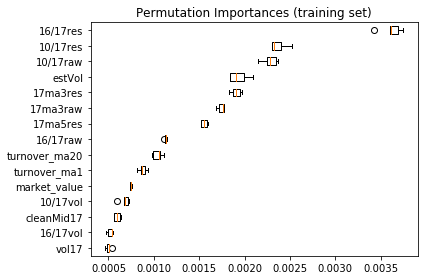

In [41]:
result = permutation_importance(
    my_model, X_train_valid, y_train_valid)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_train_valid.columns[sorted_idx]
)
ax.set_title("Permutation Importances (training set)")
fig.tight_layout()
plt.show()

## get_score

Text(0, 0.5, 'Feature Importance Score')

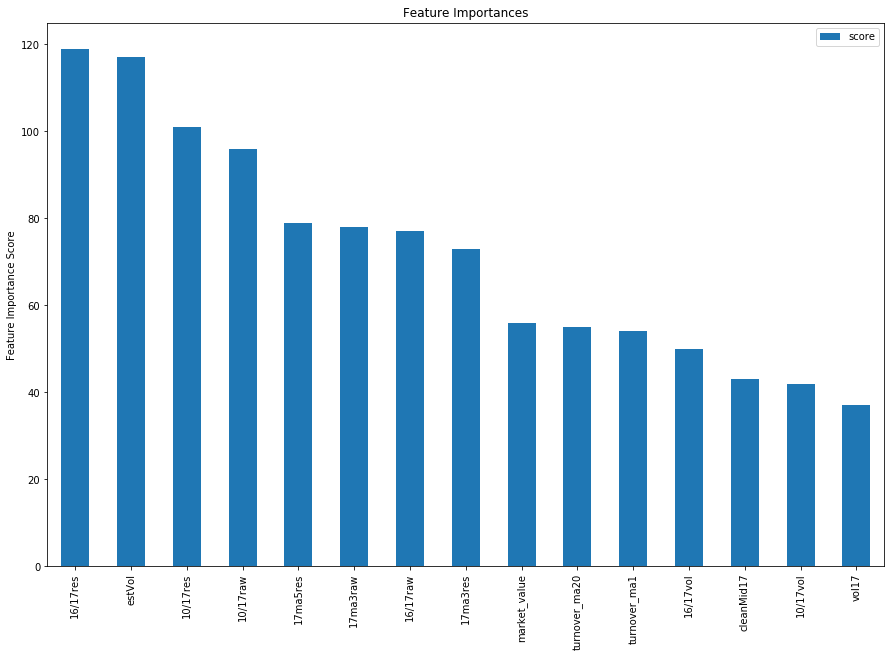

In [43]:
feature_important = my_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='bar', title='Feature Importances', figsize = (15,10)) ## plot top 40 features
plt.ylabel('Feature Importance Score')

# Plots

# binplot

###  y vs y_pred

In [21]:
y_pred = my_model.predict(X_test)  
ans = pd.DataFrame.from_dict({'y_pred': y_pred, 'y': y_test})
ans.to_csv('predictions.csv',index=False)    

In [24]:
def bin_plot(df, x_label, y_label, n_bins, path, w_label=None, scale=1, ax=None, **plot_kwargs):
        
        '''
        create a bin plot with your feature (x_label), binned into (num_bin) quantiles 
        (with equal count), on the X-axis, and the corresponding mean of the target
        variable (y_label) along with one standard error around mean on the Y-axis. 
        
        Parameters
        ----------------
        x_label: str
            label of feature x
            
        y_label: str
            label of target
            
        w_label: str
            label of weight if provided
            
        scale: float, default=1
            where to plot the point with the bin = mean(bin) * scale
            
        ax: axes
            ax to plot on, if None, the function will create one
            
        n_bins: int
            number of bins
            
        **plot_kwargs: dict
            keyword and arguments of ax.plot(x, y)
        '''
        
        key = df[x_label].values
        value = df[y_label].values
        if w_label is not None:
            w = df[w_label].values
        
            
        sorted_idx = np.argsort(key)
        chunks = np.array_split(sorted_idx, n_bins)
              
        # x axis on the plot: bin mean
        x = np.ones(n_bins)
        # boundary of the bins
        b = np.ones(n_bins)
        # y axis on the plot: bin mean
        y = np.ones(n_bins)
        # confidence of y: bin std
        c = np.ones(n_bins)
        
        for bin_idx, idx in enumerate(chunks):
            
            x[bin_idx] = np.mean(key[idx]) * scale
            b[bin_idx] = np.max(key[idx])
            if w_label is not None:
                y[bin_idx] = np.average(value[idx], weights=w[idx])
            else:
                y[bin_idx] = np.mean(value[idx])
            c[bin_idx] = np.std(value[idx]) / np.sqrt(len(value[idx]))
        
        if ax is None: 
            fig, ax = plt.subplots(figsize=(10, 6))
            
        ymin = np.min(y-c) - 0.5 * abs(np.min(y-c))
        ymax = np.max(y+c) + 0.5 * abs(np.max(y-c))
            
        ax.plot(x, y, 'o-', **plot_kwargs)
        ax.fill_between(x, y-c, y+c, color='b', alpha=0.1)
        ax.vlines(b[:-1], ymin=ymin, ymax=ymax, color='grey')
        ax.set_xticks(b[:-1])
        ax.set_ylim(bottom=ymin, top=ymax)
        ax.set_xlabel('bin boundaries, based on quantiles of {:s}'.format(x_label))
        ax.set_ylabel('within-bin means and 1 std error of {:s}'.format(y_label))
        ax.set_title('{:d} binned plot of {:s} against {:s}'.format(n_bins, y_label, x_label))
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') 
        fig.savefig(path+'bin_plot_'+x_label.replace('/','_')+'.png')

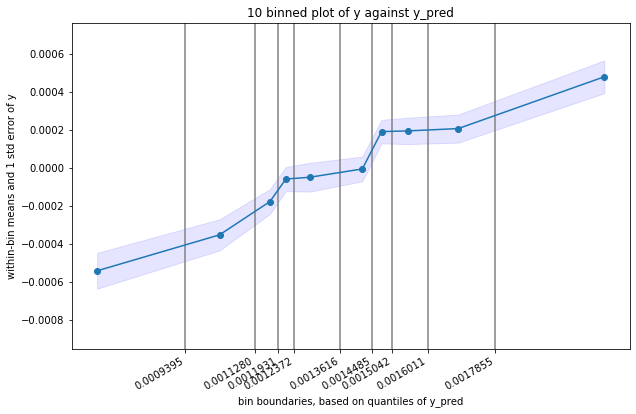

In [25]:
path = r'C:\\Users\\Lenovo\\Desktop\\2022Spring\\9899 Machine learning\\project\\latex\\'
bin_plot(ans, 'y_pred', 'y', 10, path, w_label=None, scale=1)

### y vs feature

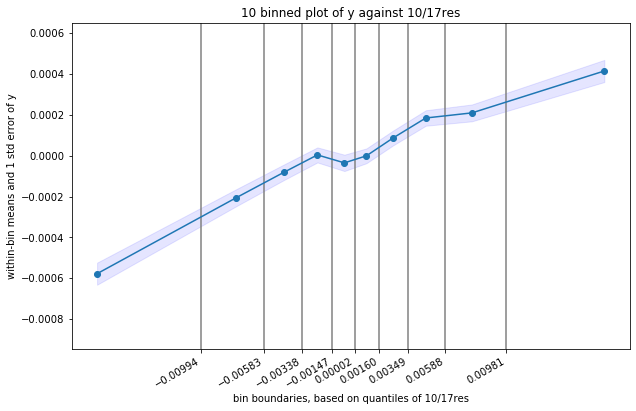

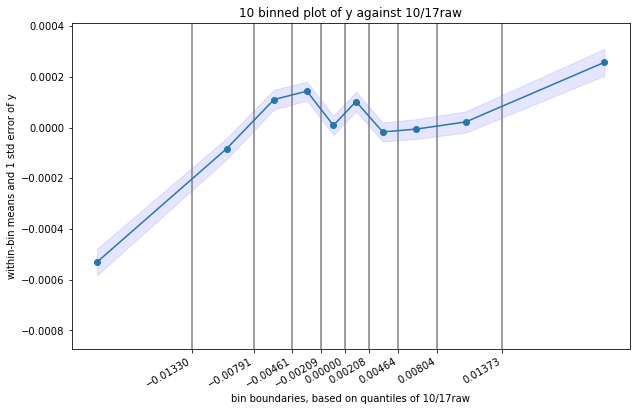

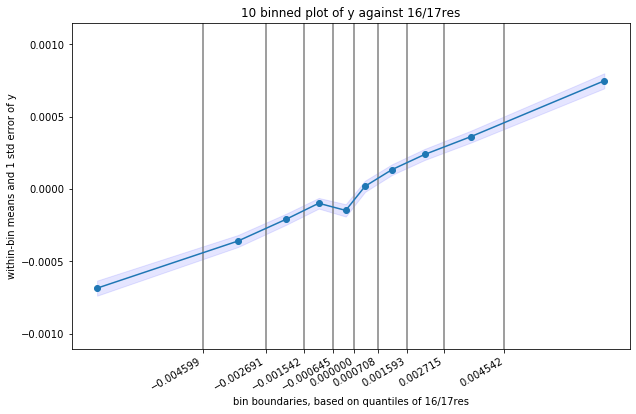

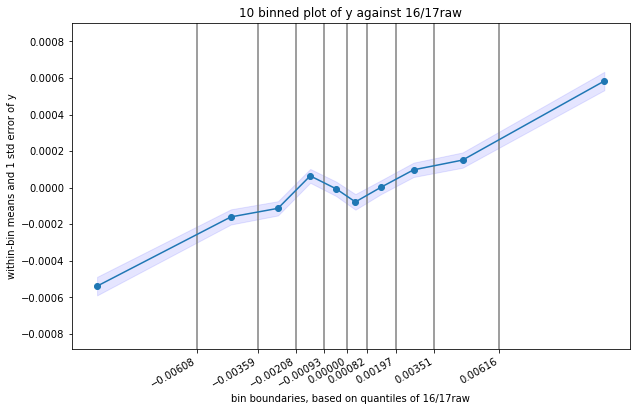

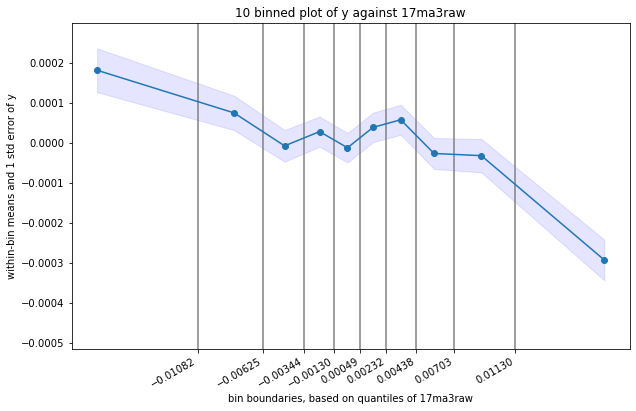

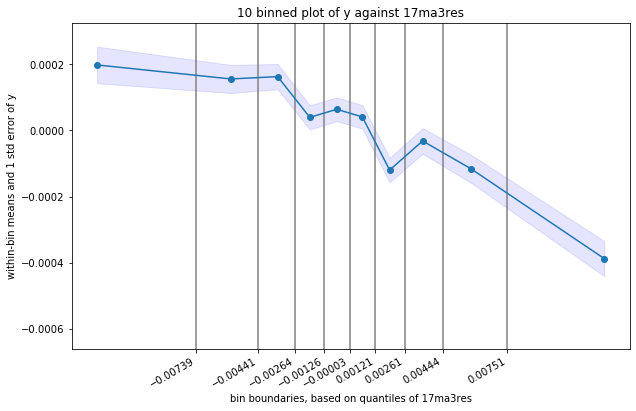

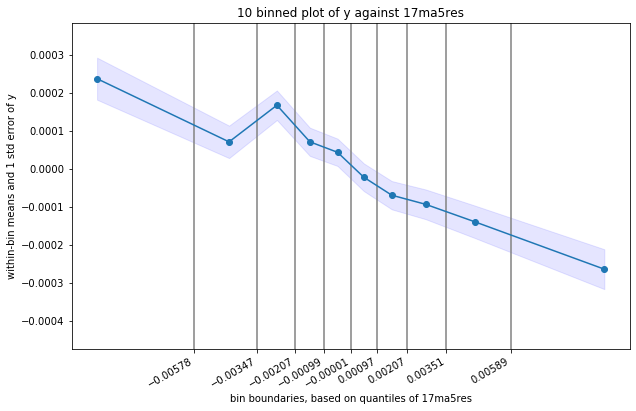

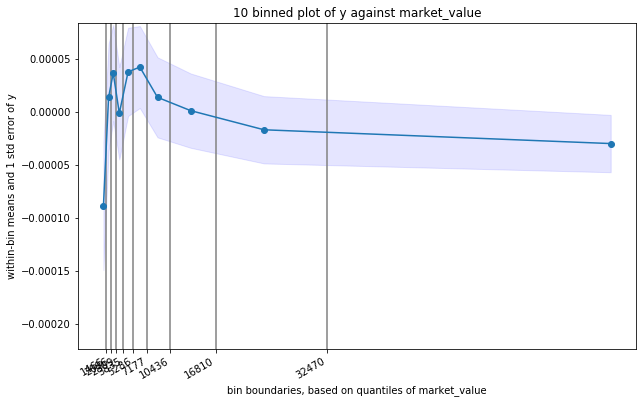

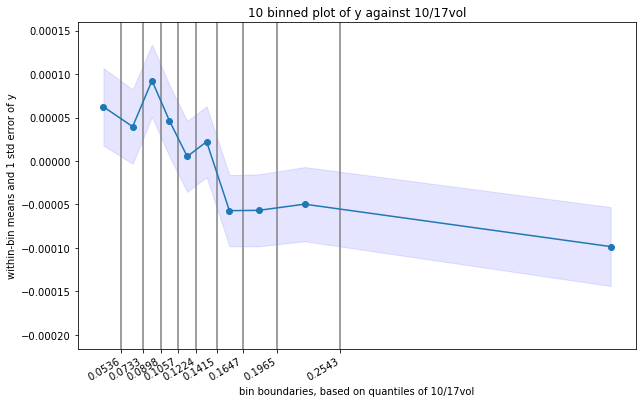

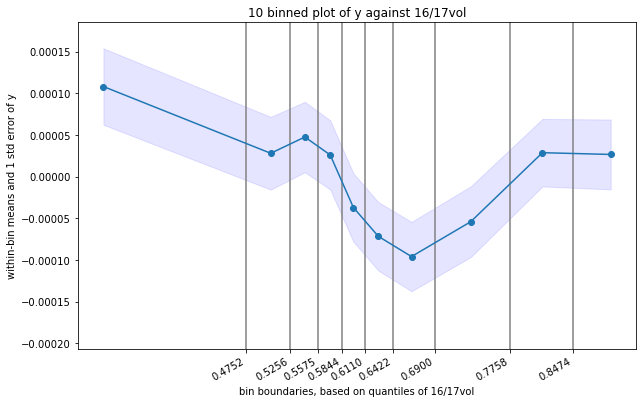

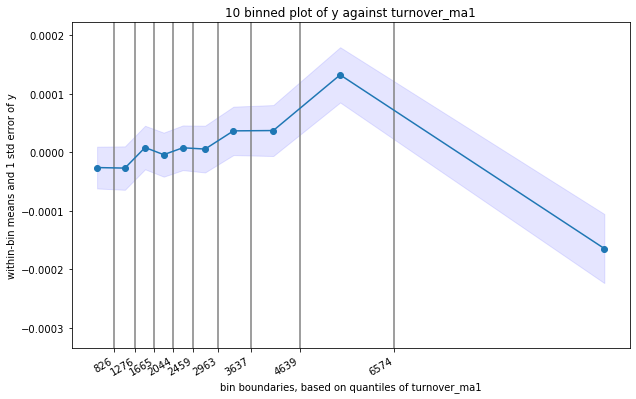

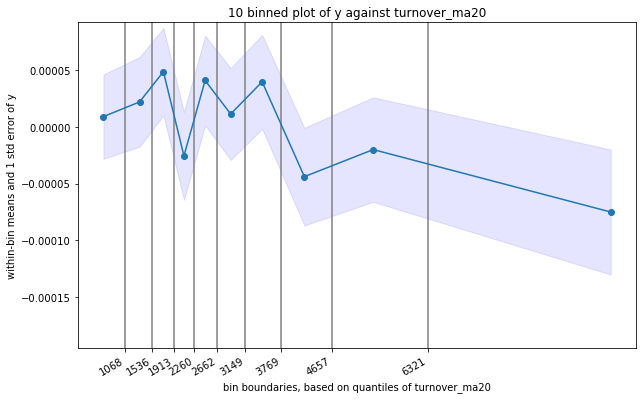

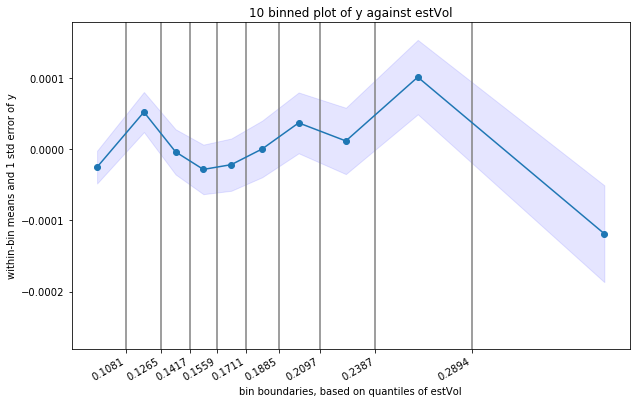

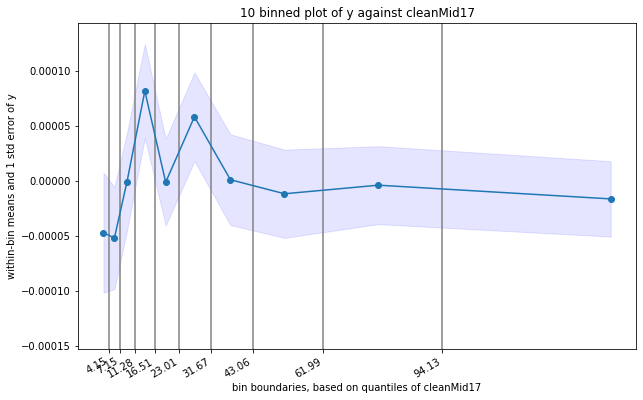

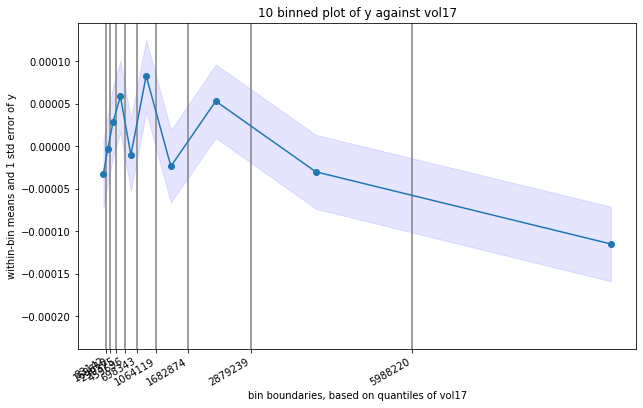

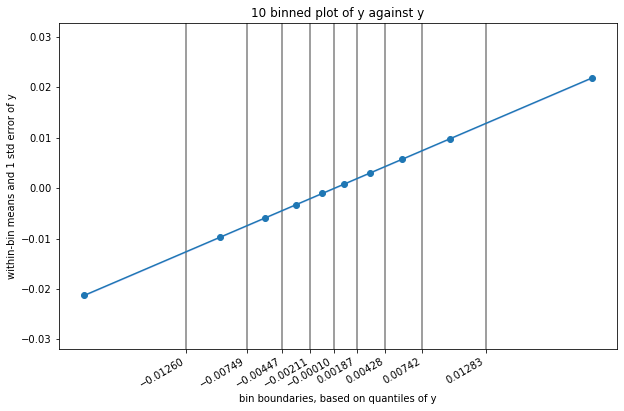

In [26]:
for col in m.columns:
    bin_plot(m, col, 'y', 10, path, w_label=None, scale=1)    

## Drift plot